In [3]:
from laika.lib.coordinates import ecef2geodetic, geodetic2ecef
%pylab inline
import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [4]:
# this is the main component of laika, and once initialized can
# immediately provide information about sattelites and signal delays
from laika import AstroDog
dog = AstroDog()

In [5]:
# For example if we want the position and speed of sattelite 7 (a GPS sat)
# at the start of January 7th 2018. Laika's custom GPSTime object is used throughout
# and can be initialized from python's datetime.

from datetime import datetime
from laika.gps_time import GPSTime
time = GPSTime.from_datetime(datetime(2018,1,7))

# We use RINEX3 PRNs to identify satellites
sat_prn = 'G07'
sat_pos, sat_vel, sat_clock_err, sat_clock_drift = dog.get_sat_info(sat_prn, time)
print("Sattelite's position in ecef(m) : \n", sat_pos, '\n')
print("Sattelite's velocity in ecef(m/s) : \n", sat_vel, '\n')
print("Sattelite's clock error(s) : \n", sat_clock_err, '\n\n')

# we can also get the pseudorange delay (tropo delay + iono delay + DCB correction)
# in the San Francisco area
receiver_position = [-2702584.60036925, -4325039.45362552,  3817393.16034817]
delay = dog.get_delay(sat_prn, time, receiver_position)
print("Sattelite's delay correction (m) in San Fransisco \n", delay)


No orbit data found for prn : R12 flagging as bad
No orbit data found for prn : R25 flagging as bad
No orbit data found for prn : R26 flagging as bad
No orbit data found for prn : R27 flagging as bad
No orbit data found for prn : R28 flagging as bad
Sattelite's position in ecef(m) : 
 [-19501731.53000003  -7580440.43900001  16817823.825     ] 

Sattelite's velocity in ecef(m/s) : 
 [1993.27528306 -613.07074562 2016.32438942] 

Sattelite's clock error(s) : 
 0.00025521380390669117 


Sattelite's delay correction (m) in San Fransisco 
 3.1049571045513886


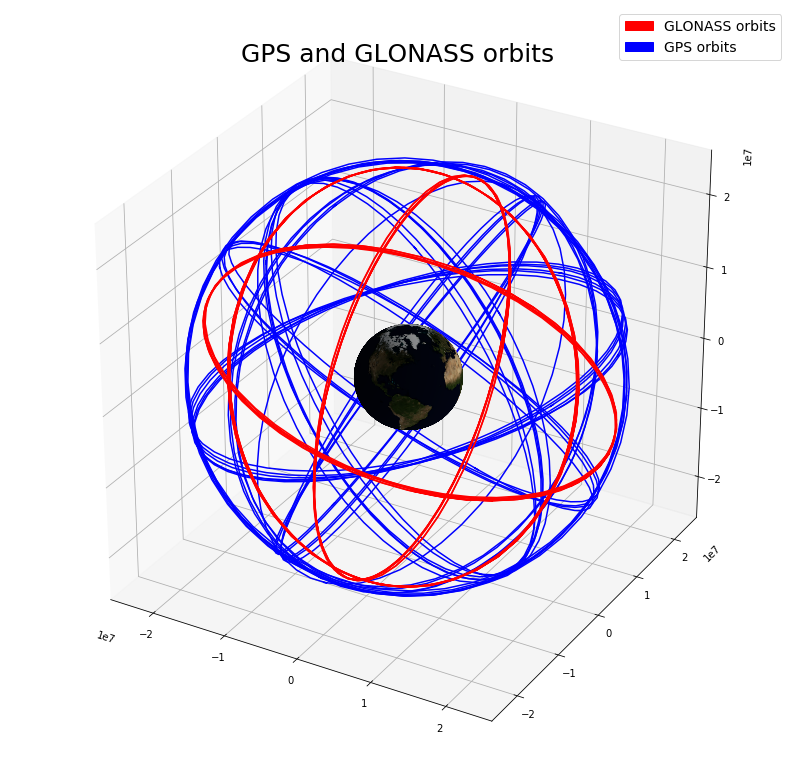

In [6]:
# We can use these helpers to plot the orbits of sattelites
# by plotting the sattelite positions over the course
# of 12 hours, which is the approximate orbital period
# of GNSS sattelites.

import PIL
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from laika.constants import EARTH_RADIUS, EARTH_ROTATION_RATE
from laika.helpers import get_constellation, get_prns_from_constellation
from laika.lib.orientation import rot_from_euler




# We start by plotting the world

# load bluemarble with PIL
bm = PIL.Image.open('bluemarble.jpg')
# it's big, so I'll rescale it, convert to array, and divide by 256 to get RGB values that matplotlib accept 
bm = np.array(bm.resize([d//5 for d in bm.size]))/256.
lons = np.linspace(-180, 180, bm.shape[1]) * np.pi/180 
lats = np.linspace(-90, 90, bm.shape[0])[::-1] * np.pi/180 
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')
x = EARTH_RADIUS*np.outer(np.cos(lons), np.cos(lats)).T
y = EARTH_RADIUS*np.outer(np.sin(lons), np.cos(lats)).T
z = EARTH_RADIUS*np.outer(np.ones(np.size(lons)), np.sin(lats)).T
ax.plot_surface(x, y, z, rstride=4, cstride=4, facecolors = bm)
ax.set_xlim(-2.5e7, 2.5e7)
ax.set_ylim(-2.5e7, 2.5e7)
ax.set_zlim(-2.5e7, 2.5e7)


# Now we get all the sattelite positions
# over a 12 hour period and plot them
sat_positions = {}
colors = ['b', 'r']
constellations = ['GPS', 'GLONASS']
for color, const in zip(colors, constellations):
  sat_prns = get_prns_from_constellation(const)
  for sat_prn in sat_prns:
    sat_positions[sat_prn] = []
    for i in range(49):
      dt = i*15*60
      sat_info = dog.get_sat_info(sat_prn, time + dt)
      if sat_info:
        theta = EARTH_ROTATION_RATE * dt
        rot_matrix = rot_from_euler((0,0,theta))
        sat_positions[sat_prn].append(rot_matrix.dot(sat_info[0]))
    if len(sat_positions[sat_prn]) > 5:
      ax.plot([p[0] for p in sat_positions[sat_prn]],
              [p[1] for p in sat_positions[sat_prn]],
              [p[2] for p in sat_positions[sat_prn]], 
              color=color)

    
patches = [mpatches.Patch(color='r', label='GLONASS orbits'),
           mpatches.Patch(color='b', label='GPS orbits')]
plt.legend(handles=patches, fontsize=14)
plt.title('GPS and GLONASS orbits', fontsize=25)
plt.show()

In [8]:
import laika.raw_gnss as raw
import laika.helpers as helpers


# this example data is the from the example segment
# of the comma2k19 dataset (research.comma.ai)

# example data contains an array of raw GNSS observables
# that were recorded during a minute of highway driving of
# a car, this array format can be used to create Laika's
# GNSSMeasurent object which can be processed with astrodog
# to then be analysed or used for position estimated.
with open('example_data/raw_gnss_ublox/value', 'br') as f:
  example_data = np.load(f)
measurements = [raw.normal_meas_from_array(m_arr) for m_arr in example_data]

# lets limit this to GPS sattelite for the sake of simplicity
measurements = [m for m in measurements if helpers.get_constellation(m.prn) == 'GPS']

# we organize the measurements by epoch and by sattelite for easy plotting
measurements_by_epoch = raw.group_measurements_by_epoch(measurements)
measurements_by_sattelite = raw.group_measurements_by_sat(measurements)

Text(0.5, 1.0, 'amount of sattelites in view')

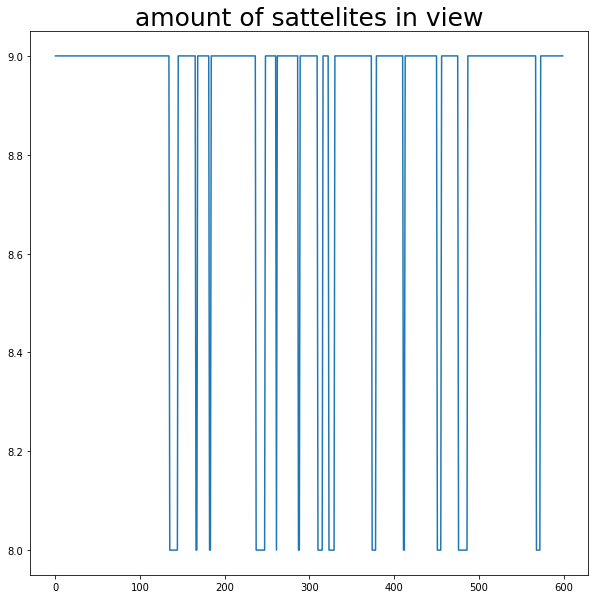

In [9]:
# we can plot the amount of sattelites in view at each epoch
figsize(10,10)
plot([len(epoch) for epoch in measurements_by_epoch])
title('amount of sattelites in view', fontsize=25)

Text(0.5, 1.0, 'PRR to for every sattelite (m/s)')

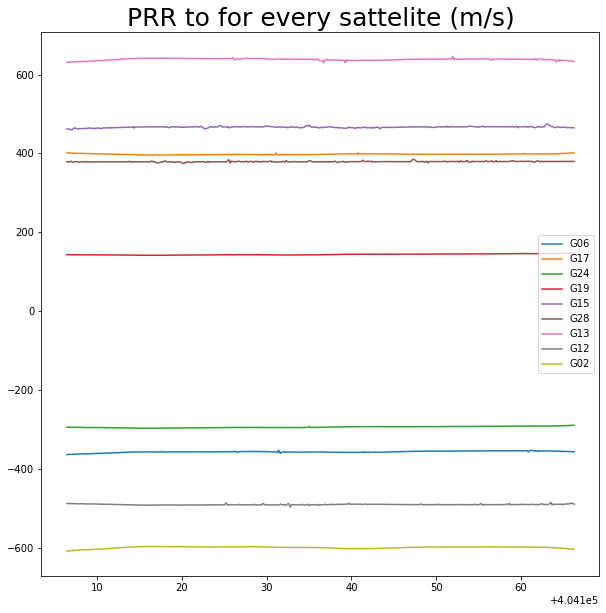

In [10]:
# we can plot the prr(pseudorange-rate) measured from the doppler shift
# towards every sattelite, we use the RINEX 3 convention to save
# the observables, so for doppler shifts on L1 its D1C.
figsize(10,10)
for prn in measurements_by_sattelite:
  plot([m.recv_time.tow for m in measurements_by_sattelite[prn]],
         [m.observables['D1C'] for m in measurements_by_sattelite[prn]], 
       label=prn)
legend()
title('PRR to for every sattelite (m/s)', fontsize=25)

Text(0.5, 1.0, 'Measured CP - predicted CP (L1 cycles)')

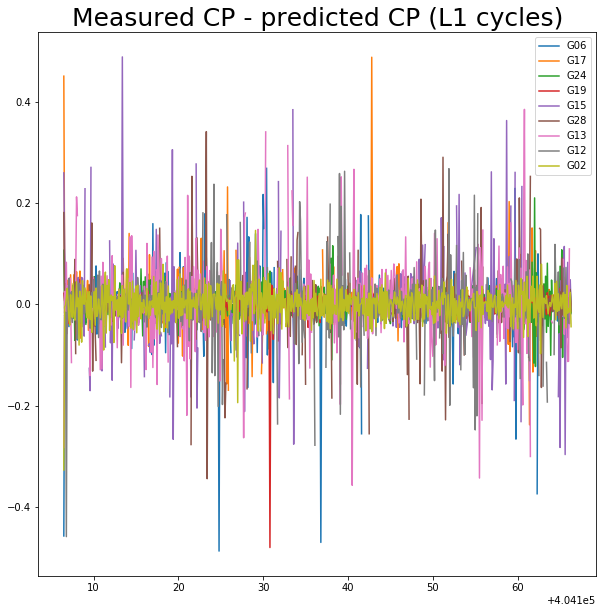

In [11]:
from laika.constants import GPS_L1, SPEED_OF_LIGHT
# Or more intrestingly we can compare the measured carrier phase 
# to a prediction of the carrier phase based on the previous carrier phase
# measurement incremented by the pseudorange_rate * timedelta
# With perfect measurements we expect this always to be around 0,
# we can see that this is often the case, but not always, indicating
# bad measurements


figsize(10,10)
for prn in measurements_by_sattelite:
  predicted_vs_measured = []
  for k in range(len(measurements_by_sattelite[prn])-1):
    prev_meas = measurements_by_sattelite[prn][k-1]
    current_meas = measurements_by_sattelite[prn][k]
    avg_prr = np.mean([prev_meas.observables['D1C'], current_meas.observables['D1C']])
    time_delta = (current_meas.recv_time - prev_meas.recv_time)
    cp_increment = time_delta * avg_prr

    cp_increment_cycles = cp_increment * (GPS_L1 / SPEED_OF_LIGHT)
    cycle_meas_diff = current_meas.observables['L1C'] - prev_meas.observables['L1C']
    predicted_vs_measured.append((cp_increment_cycles - cycle_meas_diff-.5)%1 - .5)
  plot([m.recv_time.tow for m in measurements_by_sattelite[prn][1:]], 
       predicted_vs_measured, 
       label=prn)
legend()
title('Measured CP - predicted CP (L1 cycles)', fontsize=25)

In [12]:
# now we can do some fun stuff like get some basic position
# and speed estimates with Laika's simple WLS. First we process
# and correct measurement groups with our astrodog and then solve 
# the GNSS trilateration problem

# to correct the measurements we need a receiver position estimate,
# this can be off by ~1000m, in this case we can get it by solving
# for the uncorrected measurements first.

pos_solutions, vel_solutions = [], []
corrected_measurements_by_epoch = []
for meas_epoch in measurements_by_epoch[::10]:
  processed = raw.process_measurements(meas_epoch, dog)
  est_pos = raw.calc_pos_fix(processed)[0][:3]
  corrected = raw.correct_measurements(meas_epoch, est_pos, dog)
  corrected_measurements_by_epoch.append(corrected)
  pos_solutions.append(raw.calc_pos_fix(corrected))
  # you need an estimate position to calculate a velocity fix
  vel_solutions.append(raw.calc_vel_fix(corrected, pos_solutions[-1][0]))

No orbit data found for prn : G04 flagging as bad
No orbit data found for prn : R06 flagging as bad
No orbit data found for prn : R07 flagging as bad


(-5, 5)

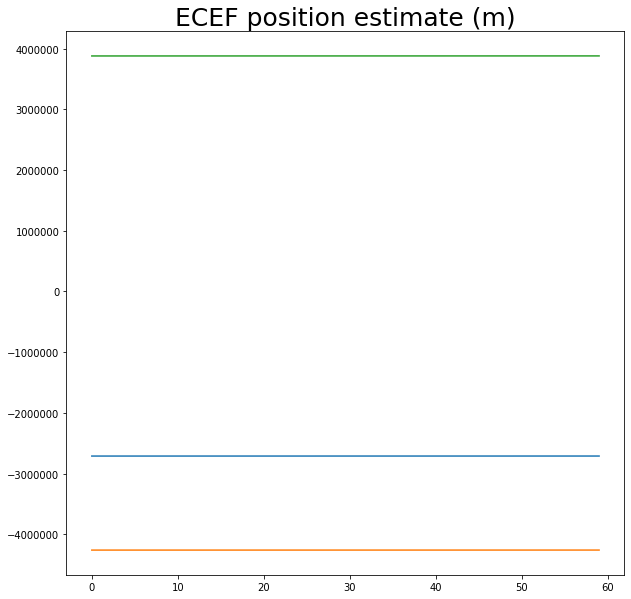

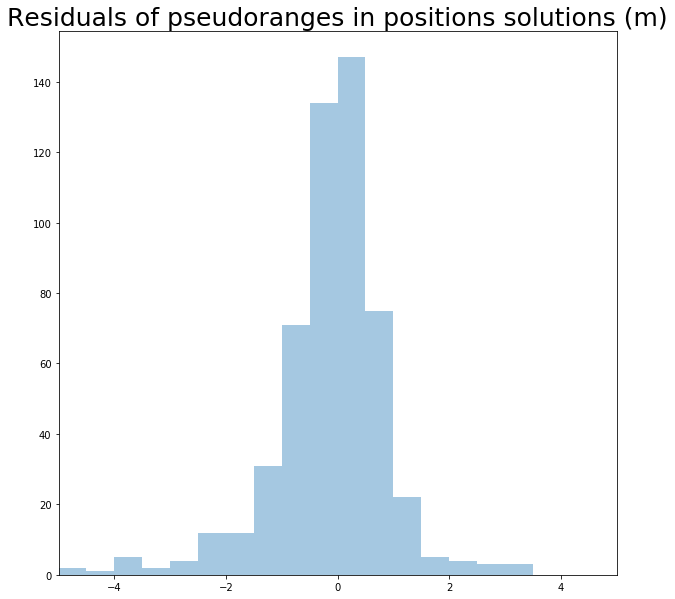

In [13]:
# we can plot the ecef positions
figsize(10,10)
figure()
title('ECEF position estimate (m)', fontsize=25)
plot([sol[0][:3] for sol in pos_solutions])

# and the resiudal distribution of the WLS solutions
figure()
title('Residuals of pseudoranges in positions solutions (m)', fontsize=25)
sns.distplot(np.concatenate([sol[1] for sol in pos_solutions]), bins=arange(-5,5,.5),kde=False)
xlim(-5,5)

(-2, 2)

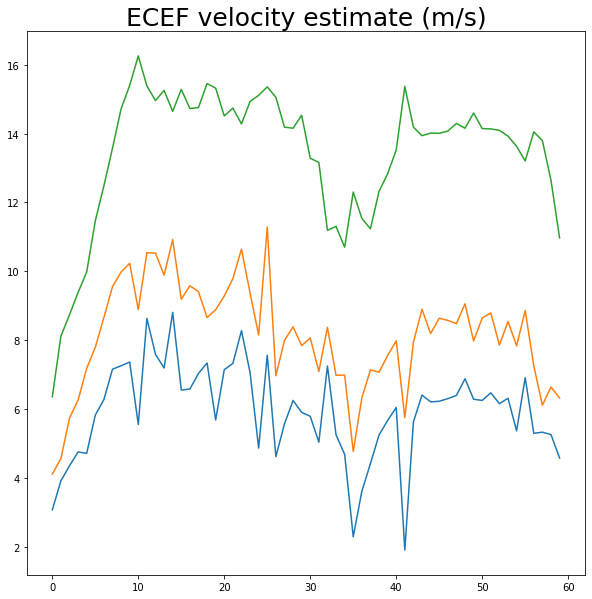

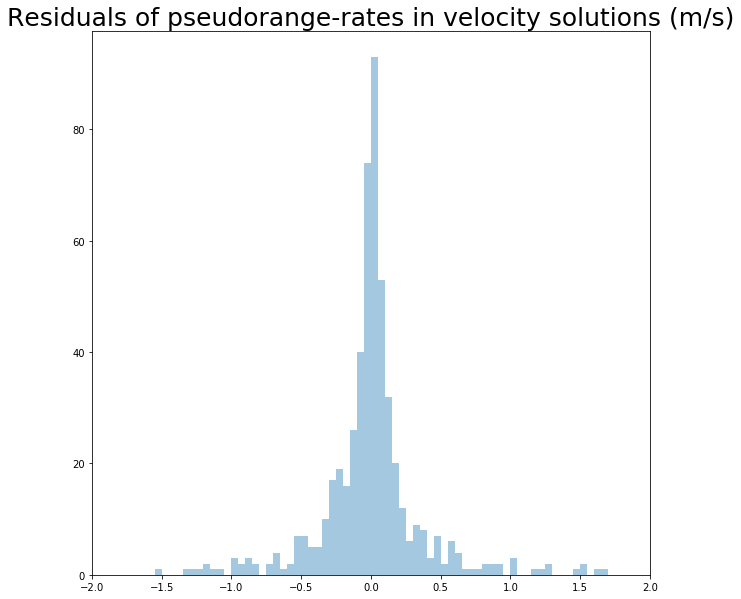

In [14]:
# we can plot the ecef velocities
figure()
figsize(10,10)
title('ECEF velocity estimate (m/s)', fontsize=25)
plot([sol[0][:3] for sol in vel_solutions])

# and the resiudal distribution of the WLS solutions
figure()
figsize(10,10)
title('Residuals of pseudorange-rates in velocity solutions (m/s)', fontsize=25)
sns.distplot(np.concatenate([sol[1] for sol in vel_solutions]), bins=arange(-2,2,.05),kde=False)
xlim(-2,2)

In [15]:
# The above residual plots give us an idea of how accurate our 
# pseudoranges are that are used for the solution, but what does that
# actually mean for the accuracy of our position estimate? Lets look
# at the geometry of the situation before we procceed.

# lets plot the world again

# load bluemarble with PIL
bm = PIL.Image.open('bluemarble.jpg')
# it's big, so I'll rescale it, convert to array, and divide by 256 to get RGB values that matplotlib accept 
bm = np.array(bm.resize([d/5 for d in bm.size]))/256.

# coordinates of the image - don't know if this is entirely accurate, but probably close
lons = np.linspace(-180, 180, bm.shape[1]) * np.pi/180 
lats = np.linspace(-90, 90, bm.shape[0])[::-1] * np.pi/180 

# repeat code from one of the examples linked to in the question, except for specifying facecolors:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='3d')

x = EARTH_RADIUS*np.outer(np.cos(lons), np.cos(lats)).T
y = EARTH_RADIUS*np.outer(np.sin(lons), np.cos(lats)).T
z = EARTH_RADIUS*np.outer(np.ones(np.size(lons)), np.sin(lats)).T
ax.plot_surface(x, y, z, rstride=4, cstride=4, facecolors = bm)

ax.set_xlim(-2.5e7, 1e7)
ax.set_ylim(-2.5e7, 1e7)
ax.set_zlim(-1e7, 2.5e7)


# Lets plot the situation for the first epoch,
# it does not change significantly over our
# minute of example data.

receiver_pos = pos_solutions[0][0]

ax.scatter([receiver_pos[0]], 
           [receiver_pos[1]], 
           [receiver_pos[2]], 
           color='w',
           #markersize=15,
           marker='+')
#sattelite_positions
sat_positions = []
for m in corrected_measurements_by_epoch[0]:
  sat_positions.append(m.sat_pos)
  ax.plot([receiver_pos[0], m.sat_pos[0]],
          [receiver_pos[1], m.sat_pos[1]],
          [receiver_pos[2], m.sat_pos[2]],
          color='b')
sat_positions = np.array(sat_positions)
ax.scatter(sat_positions[:,0],
           sat_positions[:,1],
           sat_positions[:,2],
           color='k',
           marker='^',
          linewidths=6,
          alpha=1)
ax.view_init(20,150)


plt.show()

TypeError: integer argument expected, got float

In [ ]:
from laika.lib.coordinates import LocalCoord

converter = LocalCoord.from_ecef(receiver_position)
sat_positions_ned = converter.ecef2ned(sat_positions)
azimuths_radians = np.arctan2(sat_positions_ned[:,0], sat_positions_ned[:,1])
elevation_radians = np.arctan2(-sat_positions_ned[:,2], np.linalg.norm(sat_positions_ned[:,:2],axis=1))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.scatter(azimuths_radians, elevation_radians*180/np.pi, marker='^', color='k', linewidth=6)
ax.set_yticks(range(0, 90+10, 10))                   # Define the yticks
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
yLabel = ['90', '', '', '60', '', '', '30', '', '', '']
ax.set_yticklabels(yLabel)
ax.set_title('Sattelite aximuth and elevation as seen by receiver', fontsize=25)
plt.show()

In [ ]:
# The above plot highlights an important consideration of GNSS position
# estimation. That is, the concept of DOP (https://en.wikipedia.org/wiki/Dilution_of_precision_(navigation)).
# In short, it means that if the elevations and azimuths of the sattelites in view are simial, the DOP is high. 
# A high DOP means that small errors in the pseudoranges can cause large errors in the computed position.
from laika.raw_gnss import get_DOP

print 'GDOP of this epoch is ', get_DOP(receiver_position, sat_positions)

# This data clearly has a very good DOP
# By comparing the 4 sattelites with the highest elevation
# to those 4 with the lowest we can see how different sattelite
# positions can lead to very precisions

sat_positions_sorted = sat_positions[argsort(elevation_radians)]
print 'GDOP of 4 lowest elevation sattelites of this epoch is ', get_DOP(receiver_position, sat_positions_sorted[-4:])
print 'GDOP of 4 highest elevation sattelites of this epoch is ', get_DOP(receiver_position, sat_positions_sorted[:4])